In [ ]:
!pip install datasets
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
import torch
torch.cuda.empty_cache()
import pandas as pd
import torch.nn.functional as F
import numpy as np



from collections import defaultdict
from torch import  nn 
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaModel,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Loading datasets

In [ ]:
import datasets
df= datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = df.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))

small_dataset_for_test = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))

small_eval_dataset = small_dataset_for_test.select(range(1000))
small_test_dataset = small_dataset_for_test.select(range(1000, 2000))


In [ ]:
len(small_train_dataset)

1000

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

test_dataloader = DataLoader(small_test_dataset, batch_size=8)

In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

# This model is equal to BERT + a linear layer for classification. 

model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
torch.save(model.state_dict(), "drive/MyDrive/odd/Adversarial_Attacks_NLP/best_model_state.bin" )

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss().to(device)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [ ]:
from transformers import get_scheduler
from tqdm import tqdm


num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  progress_bar = tqdm(range(n_examples))

  model.train()
  losses = []
  correct_predictions = 0

  for batch in data_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    targets = batch['labels'].to(device)
    outputs = model(**batch)
    #loss = outputs.loss

    _, preds = torch.max(outputs.logits, dim=1)
    loss = loss_fn(outputs.logits, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  return correct_predictions.double()/n_examples, np.mean(losses)


###############################################################################

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  losses = []
  correct_predictions = 0

  for i, batch in tqdm(enumerate(data_loader), desc="evaluating", total=data_loader.__len__()):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits

      targets = batch['labels']
      loss = loss_fn(logits, targets)

      _, tag_seq  = torch.max(logits, 1)

      correct_predictions += torch.sum(tag_seq == targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(num_epochs):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    lr_scheduler, 
    len(small_train_dataset)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    eval_dataloader,
    loss_fn, 
    device, 
    len(small_eval_dataset)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'best_model_state.bin')
    best_accuracy = val_acc
#%%


Epoch 1/3
----------


 12%|█▎        | 125/1000 [02:03<14:21,  1.02it/s]


Train loss 0.6960992693901062 accuracy 0.492


evaluating: 100%|██████████| 125/125 [00:37<00:00,  3.35it/s]


Val   loss 0.689402370929718 accuracy 0.534

Epoch 2/3
----------


 12%|█▎        | 125/1000 [02:01<14:10,  1.03it/s]


Train loss 0.6890728240013122 accuracy 0.549


evaluating: 100%|██████████| 125/125 [00:35<00:00,  3.53it/s]


Val   loss 0.683720118522644 accuracy 0.597

Epoch 3/3
----------


 12%|█▎        | 125/1000 [02:01<14:11,  1.03it/s]


Train loss 0.6778270812034607 accuracy 0.585


evaluating: 100%|██████████| 125/125 [00:35<00:00,  3.57it/s]

Val   loss 0.6807963142395019 accuracy 0.606

CPU times: user 7min 47s, sys: 2.57 s, total: 7min 49s
Wall time: 7min 54s


In [ ]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(small_test_dataset)
)

test_acc.item()

evaluating: 100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


0.617

# Attacks detection

In [ ]:
attacked_data = pd.read_csv('/content/drive/MyDrive/odd/imdb-attack-textfooler.csv')[['text','result_type']]
attacked_data.head()

,text,result_type
0,If you want to see a film starring Stan laurel...,1
1,"It pays to watch Reader's Digest. Or Time, if ...",1
2,Thereafter again Woody Allen seems to be compl...,1
3,Disseminate pro-American war effort film that ...,1
4,One of the most interesting things is that thi...,1


In [93]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_attack_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    tokenizer=tokenizer,
    targets=df.result_type.to_numpy(),
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
  )

###################################################################### 

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for i, d in tqdm(enumerate(data_loader), desc="evaluating", total=data_loader.__len__()):

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
      )
      _, preds = torch.max(outputs.logits, dim=1)

      probs = F.softmax(outputs.logits, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [94]:
MAX_LEN = 512
BATCH_SIZE = 8

attack_data_loader = create_attack_data_loader(attacked_data, tokenizer, MAX_LEN, BATCH_SIZE)


In [95]:
y_review_texts, y_pred, y_pred_probs,attack_label_real = get_predictions(model, attack_data_loader)




evaluating:   0%|          | 0/524 [00:00<?, ?it/s]


evaluating:   0%|          | 1/524 [00:00<02:28,  3.51it/s]


evaluating:   0%|          | 2/524 [00:00<02:25,  3.58it/s]


evaluating:   1%|          | 3/524 [00:00<02:26,  3.56it/s]


evaluating:   1%|          | 4/524 [00:01<02:24,  3.60it/s]


evaluating:   1%|          | 5/524 [00:01<02:25,  3.57it/s]


evaluating:   1%|          | 6/524 [00:01<02:24,  3.58it/s]


evaluating:   1%|▏         | 7/524 [00:01<02:22,  3.62it/s]


evaluating:   2%|▏         | 8/524 [00:02<02:23,  3.60it/s]


evaluating:   2%|▏         | 9/524 [00:02<02:25,  3.54it/s]


evaluating:   2%|▏         | 10/524 [00:02<02:23,  3.57it/s]


evaluating:   2%|▏         | 11/524 [00:03<02:21,  3.63it/s]


evaluating:   2%|▏         | 12/524 [00:03<02:19,  3.66it/s]


evaluating:   2%|▏         | 13/524 [00:03<02:19,  3.65it/s]


evaluating:   3%|▎         | 14/524 [00:03<02:21,  3.61it/s]


evaluating:   3%|▎         | 15/524 [00:04<02:20,  3.63it/s]


evaluat

In [230]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


def get_max_softmax(probas):
  prob = np.amax(probas.numpy(), axis=1)
  return prob 

def get_scores(label, proba, method = 'Max softmax'):
  fpr, tpr,thresholds = metrics.roc_curve(label,proba, pos_label=0)
  auroc = round(metrics.auc(fpr, tpr),3)
  aupr = round(average_precision_score(attack_label_real,proba,pos_label=0),3)

  print(method + ' AUROC:', auroc)
  print(method + ' AUPR:', aupr)

  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr))
  display.plot()
  plt.show()

  return auroc,aupr


####################################

def docteur_discriminator_alpha(probas, gamma):
  res = (probas**2).sum(axis = 1)
  #desc =  (1 - res > gamma*res)
  #desc = desc.int()
  return res



In [231]:
# Max softmax probabilities
prob = get_max_softmax(y_pred_probs)

# doctor score
gamma = 1
doc_alpha = docteur_discriminator_alpha(y_pred_probs, gamma)



Scores for softmax
Max softmax AUROC: 0.512
Max softmax AUPR: 0.517


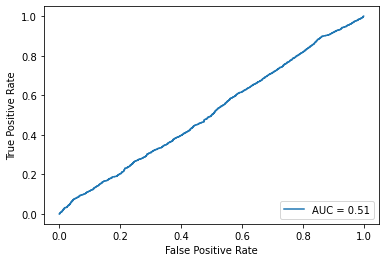


Scores for Doctor
Doctor alpha AUROC: 0.512
Doctor alpha AUPR: 0.517


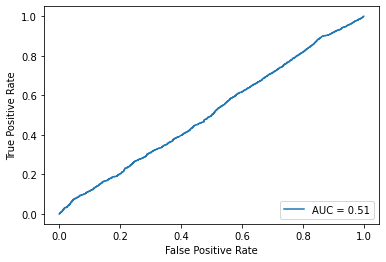

(0.512, 0.517)

In [232]:
#scores 
print('Scores for softmax')
auc, aupr = get_scores(attack_label_real, prob)
print()
print('Scores for Doctor')
get_scores(attack_label_real, doc_alpha, 'Doctor alpha')

In [222]:
prob

array([0.5369726 , 0.52800375, 0.5642645 , ..., 0.5277668 , 0.53562737,
       0.51477385], dtype=float32)

In [223]:
doc_alpha

tensor([0.5027, 0.5016, 0.5083,  ..., 0.5015, 0.5025, 0.5004])